In [32]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess

In [ ]:
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/alex_character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

In [5]:
merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

In [6]:
data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(int)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

### Introduction is [here](https://docs.google.com/document/d/1LeIT4MZN_XvUmSXgLV6pjCBFyJx-ScGt0RwY6dt2cPU/edit?tab=t.rtld0lx1xfg2)

### Let's describe our dataset

The first thing we need to know is the distribution among the archetypes. Which are the most common and which are the rarest.

Desing 3

In [114]:
px.pie(data, names="archetype", title="Archetype distribution")

The result is not unexpected. The most films are captured about extraordinary people. And statistics showed this!

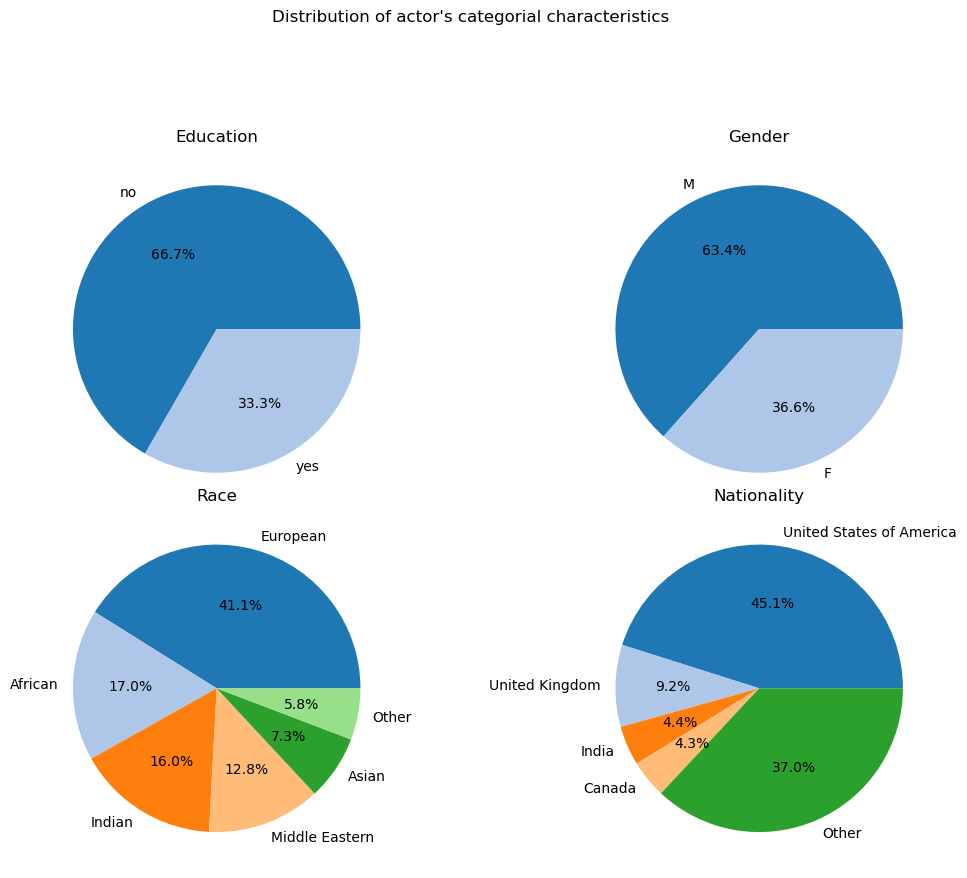

In [112]:
data_uniq_actor = data.drop_duplicates(subset=["fb_actor_id"])

plt.figure(figsize=(2*7, 2*7))

plt.suptitle("Distribution of actor's categorial characteristics")
MAX_SHOW = 10
MIN_PERCENT = 0.04
for i, (s, title) in enumerate(zip(
    ["education", "actor_gender", "race", "nationality"],
    ["Education", "Gender", "Race", "Nationality"]
)):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    
    values = data_uniq_actor[s].value_counts()
    
    values_to_show_raw = values[:MAX_SHOW].values.tolist()
    values_to_show_raw += [sum(values.values) - sum(values_to_show_raw)]

    labels_raw = values.index[:MAX_SHOW].tolist()
    labels_raw += ["Other"]
    
    sum_values_to_show = sum(values_to_show_raw)

    # everything except other
    for i in range(len(values_to_show_raw) - 1):
        if values_to_show_raw[i] < MIN_PERCENT * sum_values_to_show:
            values_to_show_raw[-1] += values_to_show_raw[i]
            values_to_show_raw[i] = 0
    good_ids = [i for i in range(len(values_to_show_raw)) if values_to_show_raw[i] > 0]
    values_to_show = [values_to_show_raw[i] for i in good_ids]
    labels = [labels_raw[i] for i in good_ids]
    
    if s == "education":
        transform_labels = {0: "no", 1: "yes"}
        labels = [transform_labels[l] for l in labels]
    
    plt.pie(
        values_to_show,
        labels=labels,
        autopct='%1.1f%%',
        colors=plt.cm.tab20.colors
    )
# plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [129]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=["Actor Height", "Actor Weight", "Simple BMI", "Number of professions"],
)

fig.add_trace(
    go.Histogram(
        x=data_uniq_actor["actor_height"],
        histnorm='probability',
        nbinsx=50,
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=data_uniq_actor["weight"],
        histnorm='probability',
        nbinsx=50,
    ),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(
        x=data_uniq_actor["actor_bmi"],
        histnorm='probability',
        nbinsx=50,
    ),
    row=2, col=1
)

fig.add_trace(
    go.Histogram(
        x=data_uniq_actor["professions_num"],
        histnorm='probability',
        nbinsx=50,
    ),
    row=2, col=2
)


fig.update_layout(
    height=800, 
    width=800, 
    title_text="Distribution of actor's numerical characteristics",
    showlegend=False,
    bargap=0.01,
)
fig.show()

Every movie on average contains a lot of different characters with a lot of different archetypes. The distribution of the how many unique archetypes every movie has

In [128]:
num_cat_by_films = data[["archetype", "fb_movie_id"]].groupby("fb_movie_id")["archetype"].agg(['unique']).reset_index()["unique"].apply(lambda x: len(x))

In [ ]:
from plotly.subplots import make_subplots
fig = go.Figure(data=
    go.Histogram(
        x=num_cat_by_films,
        histnorm='probability',
        nbinsx=12,
    ),
)

fig.update_layout(
    height=800, 
    width=800, 
    title_text="Number of unique archetype in a film",
    showlegend=False,
    bargap=0.01,
)
fig.show()